In [7]:
import numpy as np
import gym
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import copy
import seaborn as sns

from RLEnvironment import TaxiQLearner, UserTaxiEnvironment
from InverseReinforcementLearning import max_entropy
from EvaluationTools import compare_Q_matrices, simulate_episodes, actionable_sparse_Q_learning, greedy_baseline, sparse_Q_learning

# SEED EVERYTHING
RANDOM_SEED = 123
np.random.seed(RANDOM_SEED)

## 0. Initializing the data

In [8]:
# Initialize the RL Environment
rl_env = gym.make("Taxi-v3").env # Initializing the RL environment THIS SHOULD ONLY BE DONE ONCE (since the RL environment for the IRL and the recourse should be the same)
rl_env.render() # Show how the RL environment looks
rl_env.seed(RANDOM_SEED)
rl_env.action_space.seed(RANDOM_SEED)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



[123]

In [10]:
# Initialize the User's Policy
user_agent = TaxiQLearner(rl_env)
user_agent.epsilon = 0.1 
train_data, train_rewards, train_lengths = user_agent.train(1000) 

# Needs to be suboptimal, so randomly change the Q
random_states = np.random.choice(range(500), 50, replace = False)
user_agent.Q[random_states, :] = np.zeros((random_states.shape[0], 6))
random_action = np.random.choice(range(0, 6), random_states.shape[0], replace = True)
for i, ind in enumerate(random_action): 
    user_agent.Q[random_states[i], ind] = 1

Episode 0 latest length 648
Episode 25 latest length 1334
Episode 50 latest length 104
Episode 75 latest length 78
Episode 100 latest length 115
Episode 125 latest length 28
Episode 150 latest length 11
Episode 175 latest length 16
Episode 200 latest length 31
Episode 225 latest length 253
Episode 250 latest length 23
Episode 275 latest length 577
Episode 300 latest length 71
Episode 325 latest length 142
Episode 350 latest length 18
Episode 375 latest length 16
Episode 400 latest length 58
Episode 425 latest length 12
Episode 450 latest length 23
Episode 475 latest length 22
Episode 500 latest length 10
Episode 525 latest length 40
Episode 550 latest length 35
Episode 575 latest length 17
Episode 600 latest length 19
Episode 625 latest length 301
Episode 650 latest length 20
Episode 675 latest length 12
Episode 700 latest length 14
Episode 725 latest length 20
Episode 750 latest length 18
Episode 775 latest length 261
Episode 800 latest length 13
Episode 825 latest length 16
Episode 8

In [21]:
# Generate trajectory data
user_data = []
for episode in range(500): # This is the number of trajectories you want
    if episode % 100 == 0: 
        print(episode)
    D, r = user_agent.run_episode(train = False)
    user_data.append(D)
        
user_trajectories = []
for data in user_data: 
    df = pd.DataFrame(data, columns = [
      'prev_taxi_row', 
      'prev_taxi_column',
      'prev_passenger_loc',
      'prev_destination',
      'prev_state',
      'action',
      'reward', # this is the true environment rewards
      'new_taxi_row', 
      'new_taxi_column',
      'new_passenger_loc',
      'new_destination',
      'new_state'])
    user_trajectories.append(df)
    
# The ground truth Q
user_ground_truth_Q = np.copy(user_agent.Q)

0
100
200
300
400


## 1. Inferring the user's policy



In [22]:
me = max_entropy(trajectories = user_trajectories, epochs = 10, learning_rate = 0.001, epsilon = 0., environment = rl_env, minibatch_size = 100)

# create feature map
feature_map = np.eye(500) # One hot encoding of the state vector

# Perform IRL
user_reward, grads = me.max_entropy_irl(feature_map)

Iteration 0
[0.3  0.1  0.05 0.05 0.03 0.   0.03 0.01 0.   0.07]
Backward pass...
Forward pass...
100/6660
200/6660
300/6660
400/6660
500/6660
600/6660
700/6660
800/6660
900/6660
1000/6660
1100/6660
1200/6660
1300/6660
1400/6660
1500/6660
1600/6660
1700/6660
1800/6660
1900/6660
2000/6660
2100/6660


KeyboardInterrupt: 

### Do we learn a decent approximation of the user's behavior policy? 

In [15]:
num_trials = 1
random_Q_results = np.zeros(num_trials)
learned_Q_results = np.zeros(num_trials)

for j in range(num_trials): 
    print("Trial {}".format(j))
    user_env = UserTaxiEnvironment(user_reward, rl_env, multiplier= 1.) # Define a user environment
    learned_user_agent = TaxiQLearner(user_env, epsilon = 0.4)
    _ = learned_user_agent.train(1000)
    
    # Random Q matrix
    random_Q = np.zeros((500, 6))
    random_actions = (np.random.choice(range(6), 500))
    for i, action in enumerate(random_actions):
        random_Q[i, action] = 1


    learned_Q_results[j] = compare_Q_matrices(learned_user_agent.Q, user_agent.Q)
    random_Q_results[j] = compare_Q_matrices(random_Q, user_agent.Q)

Trial 0


NameError: name 'user_reward' is not defined

In [ ]:
# Show the action-selection similarilty scores
data = np.vstack((learned_Q_results, random_Q_results)).T
results_df = pd.DataFrame(data = data, columns = ['Learned user Q', 'Random user Q'])
sns.boxplot(data = results_df)
plt.ylabel("No. actions matching true Q")
plt.savefig('random_learned_boxplots.png')

In [1]:
# Visualize the Q-matrices
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

sns.heatmap(user_agent.Q[:50, :], ax=ax[0])
sns.heatmap(learned_user_agent.Q[:50, :], ax=ax[1])
sns.heatmap(random_Q[:50, :], ax=ax[2])

ax[0].set_title("User's ground truth Q")
ax[1].set_title("IRL learned Q")
ax[2].set_title("Randomly generated Q")
plt.savefig('Learned_Q_matrices.png')

NameError: name 'plt' is not defined

In [1]:
# learned user agent Q using the IRL user reward
user_Q = learned_user_agent.Q.copy()

# evaluate the user_agent with user_Q in the original environment
user_agent = TaxiQLearner(rl_env, epsilon = 0.3)
user_agent.Q = user_Q

# get the expected return for the user agent
user_avg_steps = simulate_episodes(user_agent, 100)

NameError: name 'learned_user_agent' is not defined

## 2. Improving the user's policy

In [ ]:
user_agent_Q = user_agent.Q.copy()

norms = []
reward_threshs = range(50, 150, 10)
for reward in reward_threshs:
    improved_agent = TaxiQLearner(rl_env)
    improved_agent.Q = user_agent_Q.copy()
    improved_agent.epsilon = 0.3
    
    # Train and evaluate
    current_return = reward + 1
    i = 0 
    while current_return > reward and i < 100: 
        train_data, train_rewards, train_lengths = user_agent.train(1, user_Q = user_agent_Q, sparse_penalty = 0.5) 
        if i % 5 == 0: 
            print("Evaluating Current New Policy")
            total_steps, _, _ = user_agent.evaluate(100)
            current_return = np.median(total_steps)
            print("Current Return: {}".format(current_return))
    print("DONE!\n")
    #user_agent_Q = user_agent.Q.copy()
    #new_user, new_user_return = sparse_Q_learning(rl_env, user_agent_Q, max_iters=100, goal_reward=reward, penalty=0.5, epsilon = 0.4, alpha = 0.75)
    current_norm = np.linalg.norm(user_agent_Q - improved_agent.Q, ord = 1)
    norms.append(current_norm)

Episode 0 latest length 61
Evaluating Current New Policy
Evaluation episode 0: 65 steps
Evaluation episode 25: 144 steps
Evaluation episode 50: 11110 steps
Evaluation episode 75: 189 steps
Current Return: 147.5
Episode 0 latest length 95
Evaluating Current New Policy
Evaluation episode 0: 315 steps
Evaluation episode 25: 349 steps
Evaluation episode 50: 29 steps
Evaluation episode 75: 162 steps
Current Return: 131.0
Episode 0 latest length 19
Evaluating Current New Policy
Evaluation episode 0: 295 steps
Evaluation episode 25: 205 steps
Evaluation episode 50: 18 steps
Evaluation episode 75: 709 steps
Current Return: 108.0
Episode 0 latest length 82
Evaluating Current New Policy
Evaluation episode 0: 18 steps
Evaluation episode 25: 17 steps
Evaluation episode 50: 2789 steps
Evaluation episode 75: 249 steps
Current Return: 114.0
Episode 0 latest length 19
Evaluating Current New Policy
Evaluation episode 0: 14 steps
Evaluation episode 25: 64 steps
Evaluation episode 50: 80 steps
Evaluation

### Testing User Preference

In [ ]:
# 6 actions: south, north, east, west, pickup passenger, dropoff passenger
# we assume that taxi user does not like taking left turns 
# so we downweight action 3
avoid_left_turns = lambda s, a: -10 if (a == 3) else -5

new_user, new_user_return, user_return = actionable_sparse_Q_learning(user_agent_Q, max_iters=20, min_diff=20, percentage_diff=0.15, penalty=avoid_left_turns)

## 3. Evaluation

### Results for the Greedy Baseline

In [ ]:
# learn the optimal Q value using the true reward
optimal_user_agent = TaxiQLearner(rl_env, epsilon = 0.3)
_ = optimal_user_agent.train(500)
optimal_Q = optimal_user_agent.Q.copy()
# get the expected return for the optimal user agent
optimal_user_avg_steps = simulate_episodes(optimal_user_agent, num_episodes_evaluation)

In [ ]:
# calculate the absolute difference between the optimal Q 
Q_diff = abs(optimal_Q - user_Q)
# sum of abs diff per state
Q_diff_state = Q_diff.sum(axis = 1)
print('number of the absolute differences that are 0 out of 500 differences: {}'.format(
    (Q_diff_state ==0).sum()))
print('number of distinct non-zero abs differences: {}'.format(
    len(set(Q_diff_state[Q_diff_state != 0]))))

# if there is no duplicate values, then we can use the abs difference as the key of the dict
# a dictionary of tuple: key = abs difference, value = row (state)
abs_diff_dict = dict()
for state, abs_diff in enumerate(Q_diff_state):
    if abs_diff != 0:
        abs_diff_dict[abs_diff] = state

# sort the absolute difference in the ascending order
sorted_abs_diff = sorted(abs_diff_dict.keys(), reverse = False)

In [ ]:
min_diff = user_avg_steps # how much we want to improve the average user steps

i = 0
current_abs_diff = sorted_abs_diff[0] # ith smallest abs diff
# get the [s,{a}] to be changed
state_changed = abs_diff_dict[current_abs_diff]
# change Q user [s,a] to optimal Q[s,a]
current_Q = user_Q.copy()
current_Q[state_changed, :] = optimal_Q[state_changed, :]

# evaluate the current Q on the original RL environment
current_user_agent = TaxiQLearner(rl_env, epsilon = 0.4)
current_user_agent.Q = current_Q
current_user_avg_steps = simulate_episodes(current_user_agent, 100)

# keep track of current user avg_steps
list_avg_step_history = [user_avg_steps, current_user_avg_steps]
list_Q_diff = [0, current_abs_diff]

# stop if current return <= user_avg_steps - some constant
while ((current_user_avg_steps > user_avg_steps - min_diff) and i < len(abs_diff_dict) - 1):
    i += 1
    # keep updating current user Q
    current_abs_diff = sorted_abs_diff[i] # ith smallest abs diff
    # get the [s,a] to be changed
    state_changed = abs_diff_dict[current_abs_diff]
    # change Q user [s,a] to optimal Q[s,a]
    current_Q[state_changed, :] = optimal_Q[state_changed, :]
    
    # evaluate the current Q on the original RL environment
    current_user_agent = TaxiQLearner(rl_env, epsilon = 0.4)
    current_user_agent.Q = current_Q
    current_user_avg_steps = simulate_episodes(current_user_agent, 100)
    print('iteration: {}, avg steps: {}'.format(i, current_user_avg_steps))
    
    list_avg_step_history.append(current_user_avg_steps)
    list_Q_diff.append(list_Q_diff[-1] + current_abs_diff)


### Results for Our Method

### Comparison of Greedy vs. Our method

In [12]:
import pickle
baseline_res = pickle.load(open("baseline.pickle", "rb"))
our_res = pickle.load(open("method.pickle", "rb"))

baseline_norms = np.array(baseline_res["list_Q_diff"])
baseline_lengths = np.array(baseline_res["list_avg_step_history"])
our_norms = np.array(our_res["norms"])
our_lengths = np.array(our_res["reward_threshs"])

In [11]:
baseline_res

{'list_Q_diff': [37.45620314585692,
  25.541273402072488,
  1.7343786219090906,
  0.4959814006382462,
  0.4959814006382462,
  0.4959814006382462,
  0.4959814006382462,
  0.4959814006382462,
  0.4959814006382462,
  0.4959814006382462],
 'list_avg_step_history': [47.5,
  58.5,
  70.0,
  72.5,
  73.0,
  80.5,
  104.5,
  71.0,
  92.0,
  102.0]}

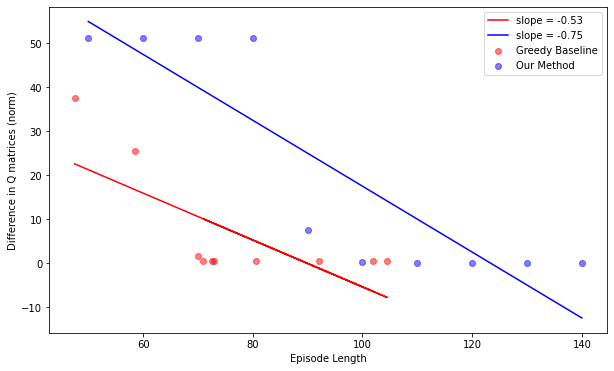

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
baseline_ind = list(range(0, len(baseline_res["list_avg_step_history"]), 50))

ax.scatter(baseline_lengths, baseline_norms, color = "red", alpha = 0.5, label="Greedy Baseline")
ax.scatter(our_lengths, our_norms, color="blue", alpha = 0.5, label="Our Method")

#ax.set_title('Steps taken to success versus Sparsity of counterfactual', fontsize = 14)
plt.xlabel('Episode Length')
plt.ylabel('Difference in Q matrices (norm)')

# fit a regression line
m_baseline, b_baseline = np.polyfit(baseline_lengths, baseline_norms, 1)
m_ours, b_ours = np.polyfit(our_lengths, our_norms, 1)

plt.plot(baseline_lengths, m_baseline*baseline_lengths + b_baseline, color = 'red', label = 'slope = {}'.format(np.round(m_baseline, 2)))
plt.plot(our_lengths, m_ours*our_lengths + b_ours, color = 'blue', label = 'slope = {}'.format(np.round(m_ours, 2)))
#plt.ylim((-100, 2600))
plt.legend()
plt.show()

In [61]:
our_norms

array([51.15878533, 51.15878533, 51.15878533, 51.15878533,  7.67013817,
        0.28463933,  0.05212735,  0.05212735,  0.        ,  0.        ])

In [36]:
np.polyfit(baseline_res["list_avg_step_history"],  baseline_res["list_Q_diff"], 1)

array([-0.76385414, 88.25428243])